# Total variation de-noising

_Total variation de-noising_ seeks to remove noise from a noisy picture.

The following picture can be loaded:

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


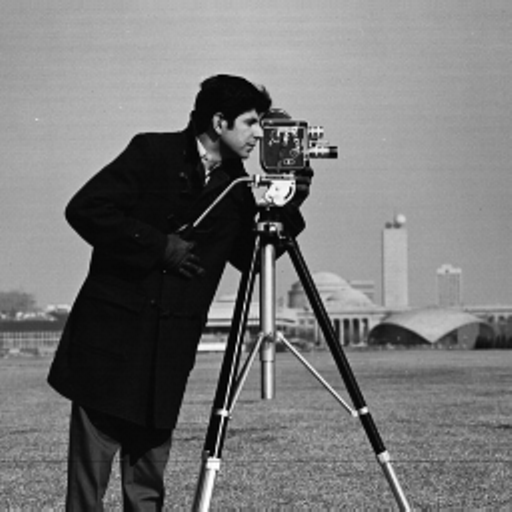

In [1]:
using Pkg, Random, Images, TestImages, LinearAlgebra

Pkg.activate("."); Pkg.instantiate(); Random.seed!(123) # For reproducibility

Xgt = testimage("cameraman")


Some noise can then be added to this figure:


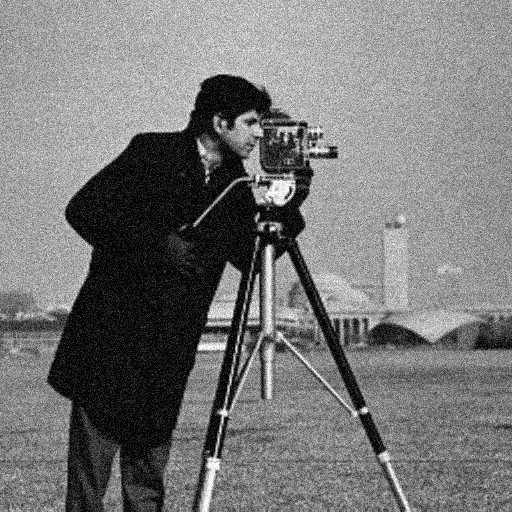

In [2]:
Y = Xgt .+ sqrt(0.006*norm(Xgt,Inf))*randn(size(Xgt)) # add noise
Y[Y .< 0] .= 0. #make sure pixels are in range
Y[Y .> 1] .= 1.
Gray.(Y)


It is now seeked to recover the ground truth $\mathbf{X}_{gt}$ from the noisy image $\mathbf{Y}$.

This ca by achieved by assuming that neighbor pixels of the sought uncorrupted image $\mathbf{X}^{\star}$
are similar, namely that 
$$\sqrt{ 
| x_{i+1,j}^{\star}-x_{i,j}^{\star} |^2+
| x_{i,j+1}^{\star}-x_{i,j}^{\star} |^2
}$$ 
where $x_{i,j}^{\star}$ is the $(i, j)$-th
component of $\mathbf{X}^{\star}$. 
This enforces the image to have sharp edges, namely a sparse gradient. The following
optimization problem can be formulated:
$$ \mathbf{X}^{\star} = \underset{\mathbf{X}}{\text{argmin}} \tfrac{1}{2} \| \mathbf{X} - \mathbf{Y} \|^2 + \lambda \| V  \mathbf{X} \|_{2,1}, $$
where $V$ maps $\mathbf{X}$ into a matrix having in its $j$-th column the vectorized forward 
finite difference gradient over the $j$-th direction and $\| \cdot \|_{2,1}$ is the mixed norm which sums the $l_2$-norm rows of $V  \mathbf{X}$.

The operator $V$ can be created using the `AbstractOperators.jl` package:

In [3]:
using AbstractOperators

V = Variation(size(Y))

Ʋ  ℝ^(512, 512) -> ℝ^(262144, 2) 


Unfortunately this problem cannot be solved using proximal gradient algorithms: that is because the operator $V$ appears in the nonsmooth part of the cost function $g(\cdot) = \lambda \| \cdot \|_{2,1}$ and leads to a non-trivial proximal operator.

However using Fenchel's duality theorem it is possible to convert this problem into: 

$$ \mathbf{U}^{\star} =  
\underset{\mathbf{U}}{\text{argmin}} \tfrac{1}{2} \| - V^* \mathbf{U} + \mathbf{Y} \|^2 
+ g^*(\mathbf{U}), $$

where $\mathbf{U}$ are the _dual variables_ and $g^*$ is the _convex conjugate_ of $g$.

Since the smooth part of the original problem is _strongly convex_ than its dual is smooth and allows the usage of proximal gradient algorithms:

In [4]:
using StructuredOptimization

U = Variable(size(V,1)...)
lambda = 0.07
Y = float(Y)

@minimize ls(-V'*U+Y) + conj(lambda*norm(U,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast=true);

Finally the primal solution $\mathbf{X}^{\star}$ can be obtained from the dual solution $\mathbf{X}^{\star}$ 
by exploiting the fact that $\mathbf{X}^\star = \nabla f^*( -V^* \mathbf{U}^\star).$

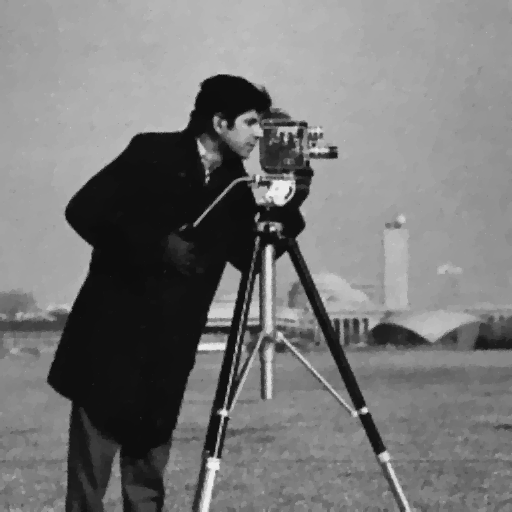

In [5]:
X = Gray.(-V'*(~U)+Y)
